In [70]:
import pandas as pd
from matplotlib import patches, path
import matplotlib.pyplot as plt
import pandas as pd
from hydra import initialize, compose
from assembly_tools import format_table, extract_raw_performance, load_finetuning, load_experimental_grid, build_exp1

In [71]:
# transformer and unidirectional finetuning.
res = load_finetuning()
res = res[res["cp_architecture"] == "transformer"]
res2 = load_finetuning("causal_discovery_zoo/cp_finetuned_2/")

fail: causal_discovery_zoo/cp_finetuned_2/2025-02-26 08:02:37.141247
fail: causal_discovery_zoo/cp_finetuned_2/2025-02-26 04:18:22.916705
fail: causal_discovery_zoo/cp_finetuned_2/2025-02-25 19:22:38.698666


In [72]:
# Best run. These model weights were used for producing the finetuning results and can be found under causal_discovery_zoo/models/cp_models/finetuned_best
pd.concat([res,res2]).sort_values("f1_max_test", ascending=False).iloc[0]

label_path                                                        ../../datasets/random_5/bav.p
data_path                                                   ../../product/rivers_ts_bavaria.csv
restrict_to                                                                                  -1
seed                                                                                       4242
save_finetune_path                                                              cp_finetuned_2/
train_data_path                                                ../product/rivers_ts_bavaria.csv
test_path                                                 ../product/rivers_ts_east_germany.csv
pretrained_path                                           methods/cp_models/pretrained_weights/
window_size                                                                                 600
cp_architecture                                                                  unidirectional
batch_size                              

### Aggregate final graphics via finetuning.

In [74]:
%%capture
exp1 = build_exp1(scoring="Individual AUROC", null_name="Null AUROC")
best= exp1.max()
before = exp1.iloc[-2:].max()

In [75]:
with initialize(version_base=None, config_path="config/"):
    cfg = compose(config_name='extract.yaml')
scoring = "Individual AUROC"

runs= load_experimental_grid(mypath=cfg.data_path + "exp3/", method_name="cp").T
runs = runs[["label_path", scoring]].set_index("label_path")
runs.index = [x[-2] for x in runs.index.str.split("/")]

In [87]:
df = pd.concat([best,before,runs], axis=1)
df.columns = ["Best","Before", "After"]

In [88]:
df["Increase"] =  df["After"] - df["Before"]
df["Increase2"] =  df["After"] - df["Best"]
df.drop(index=["disjoint_10"],inplace=True)

In [229]:
df.rename(columns={"Before": "CP without finetuning", "After": "CP with finetuning", "Best": "Best CD (Exp 1)"}, inplace=True)

In [233]:
def gain_graph(ax, df, data_n = ["Before", "After", "Increase"], color=["#FFA07A", "#4682B4"]):
    # dont plot increase
    ret = df[data_n[:2]].plot(
        kind="bar", ax=ax, color=color, width=0.5, edgecolor="black"
    )

    # for each bar in the plot, add the value on below it
    for i, p in enumerate(ax.patches):
        ax.annotate(
            text=f"{p.get_height():.2f}",
            xy=(p.get_x() + 0.055, p.get_height() - 0.07),
            fontsize=11,
            rotation=90,
            color="white" if i > 9 else "black",
        )

    # draw an fancy arrow between the two bars
    for i in range(len(df)):
        x_s = ax.patches[i].get_x() + (ax.patches[i].get_width() / 2)
        x_e = ax.patches[i + len(df)].get_x() + ax.patches[i + len(df)].get_width() / 2
        y_s = ax.patches[i].get_height()
        y_e = ax.patches[i + len(df)].get_height()

        # calc path
        increase = df[data_n[2]].iloc[i]
        if increase > 0:
            top = y_s + increase + 0.02
            text_color = "green"
        else:
            top = y_s + 0.02
            text_color = "red"
        to_path = path.Path(
            [
                (x_s, y_s),
                (x_s, top),
                (x_e, top),
                (x_e, y_e + 0.002),
            ]
        )
        # draw arrow
        arrow = patches.FancyArrowPatch(
            path=to_path,
            arrowstyle="-|>, head_length=2.5, head_width=2.5",
            color=text_color,
            lw=1.5,
            linestyle=(0, (3, 5)),
        )
        ax.add_patch(arrow)

        # add the increase value on top of the arrow
        sign = "+" if increase > 0 else ""
        ax.annotate(
            text=f"{sign}{increase:.2f}",
            xy=(x_s + (x_e - x_s) / 2, top + 0.01),
            fontsize=11,
            color=text_color,
            ha="center",
            weight="bold",
        )

    # set the x-axis labels to be the country names
    ax.set_xticklabels(df.index, rotation=20, ha="right", fontsize=10)
    ax.set_ylabel("AUROC", fontsize=12)
    # set the yaxis tick labels size
    ax.yaxis.set_tick_params(labelsize=12)
    # disable top and right spines
    #ax.spines["top"].set_visible(False)
    #ax.spines["right"].set_visible(False)
    
    ax.set_ylim([0.48,0.95])


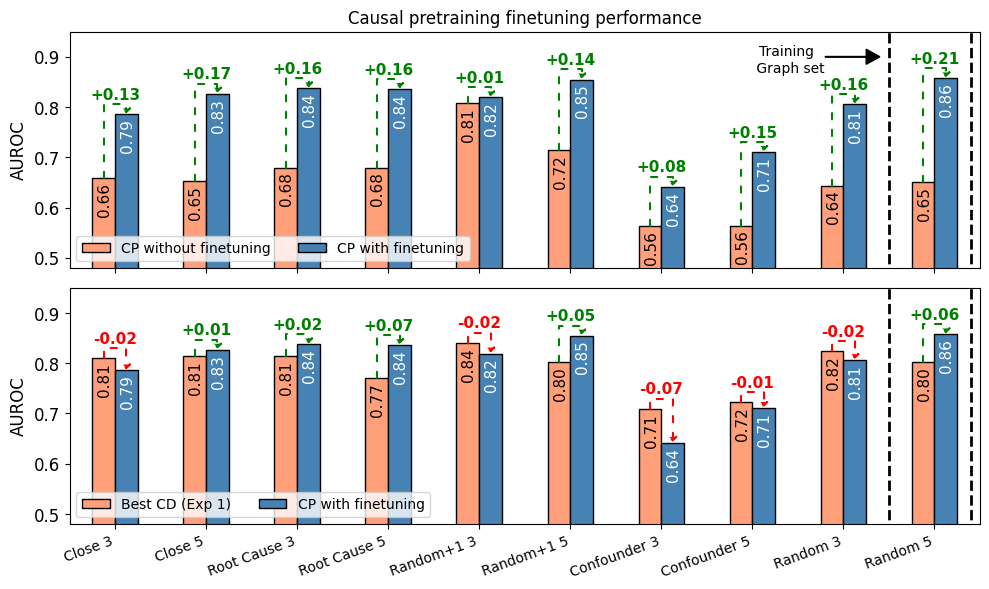

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True)
gain_graph(ax[0], df, ["CP without finetuning", "CP with finetuning", "Increase"], color=["#FFA07A", "#4682B4"])
gain_graph(ax[1], df, ["Best CD (Exp 1)", "CP with finetuning", "Increase2"],color=["C2", "#4682B4"])

ax[0].set_title("Causal pretraining finetuning performance", fontsize=12)
plt.tight_layout()

ax[0].set_yticks([0.5,0.6,0.7,0.8,0.9],[0.5,0.6,0.7,0.8,0.9])
ax[1].set_yticks([0.5,0.6,0.7,0.8,0.9],[0.5,0.6,0.7,0.8,0.9])


ax[0].vlines(8.5, 0.4,1, linestyle="dashed", color="black", linewidth=2)
ax[0].vlines(9.4, 0.4,1, linestyle="dashed", color="black", linewidth=2)
ax[1].vlines(8.5, 0.4,1, linestyle="dashed", color="black", linewidth=2)
ax[1].vlines(9.4, 0.4,1, linestyle="dashed", color="black", linewidth=2)

ax[0].legend(loc=3, ncols=2)
ax[1].legend(loc=3, ncols=2)

ax[0].set_xticklabels(["Close 3", "Close 5", "Root Cause 3", "Root Cause 5", "Random+1 3", "Random+1 5", "Confounder 3", "Confounder 5", "Random 3", "Random 5"], fontsize=8)

ax[0].text(7.4, 0.87,"Training \n Graph set", ha="center", fontsize=10)
#ax[1].text(8., 0.91,"Training \n Graph set", ha="center", fontsize=8)
ax[0].arrow(7.8, 0.9, 0.6,0., length_includes_head=True, head_width=0.03, head_length=0.15, facecolor="black")

fig.savefig("../graphics/fine_tune.pdf", bbox_inches="tight")